# Анализ пользователей мобильного приложения

Дизайнеры решили изменить шрифт во всем приложении, необходимо узнать, повлияет ли это на воронку продаж ли нет.

Задачи:
1. Анализ воронки продаж. Как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

2. Исследование результатов A/A/B-эксперимента. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо понять, есть ли различия между группами.

<b>Описание данных</b>

Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [31]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from scipy import stats as st
import numpy as np
import math as mth
from plotly import graph_objects as go
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

In [32]:
logs_exp = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
logs_exp.columns = ['event_name','device_id_hash','event_times_tamp','expld']
logs_exp.head()

,event_name,device_id_hash,event_times_tamp,expld
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [33]:
# Посмотрим входные данные на наличие пропусков, дубликатов, тип данных по столбцам
print('Таблица: rest_data ')
print('Количество дубликатов: ',logs_exp.duplicated().sum())
print('')
logs_exp.info()
print('')
display('Количество пропусков:',logs_exp.isna().sum())
display(logs_exp.head(5))
print('_____________________________________________________________________________________________________')

Таблица: rest_data 
Количество дубликатов:  413

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event_name          244126 non-null object
device_id_hash      244126 non-null int64
event_times_tamp    244126 non-null int64
expld               244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB



'Количество пропусков:'

event_name          0
device_id_hash      0
event_times_tamp    0
expld               0
dtype: int64

,event_name,device_id_hash,event_times_tamp,expld
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


_____________________________________________________________________________________________________


1. Удалим имующиеся дубликаты
2. Преобразуем столбец event_times_tamp в datetime
3. Добавим столбец с датой

In [34]:
# Удаление дубликатов
logs_exp = logs_exp.drop_duplicates().reset_index(drop = True)
logs_exp.duplicated().sum()

0

In [36]:
# Преобразование типов данных
logs_exp['event_times_tamp'] = pd.to_datetime(logs_exp['event_times_tamp'], unit='s')
logs_exp['date'] = logs_exp['event_times_tamp'].dt.date
logs_exp['date'] = logs_exp['date'].astype('datetime64[ns]')
logs_exp.head()

,event_name,device_id_hash,event_times_tamp,expld,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


## Изучение данных

### Сколько всего событий в логе

In [37]:
logs_exp['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [38]:
logs_exp['event_name'].count()

243713

- 5 уникальных событий в логе

- 243713 событий записано в data

### Сколько всего пользователей в логе

In [39]:
logs_exp['device_id_hash'].nunique()

7551

- В логе 7551 уникальных пользователей

### Сколько в среднем событий приходится на пользователя

In [40]:
round(logs_exp['event_name'].count()/logs_exp['device_id_hash'].nunique())

32

- В среднем 32 события приходится на 1 пользователя

### За какой период данные

In [41]:
print('min:',min(logs_exp['date']), 'max:',max(logs_exp['date']))
print('Количество дней:',max(logs_exp['date'])-min(logs_exp['date']))

min: 2019-07-25 00:00:00 max: 2019-08-07 00:00:00
Количество дней: 13 days 00:00:00


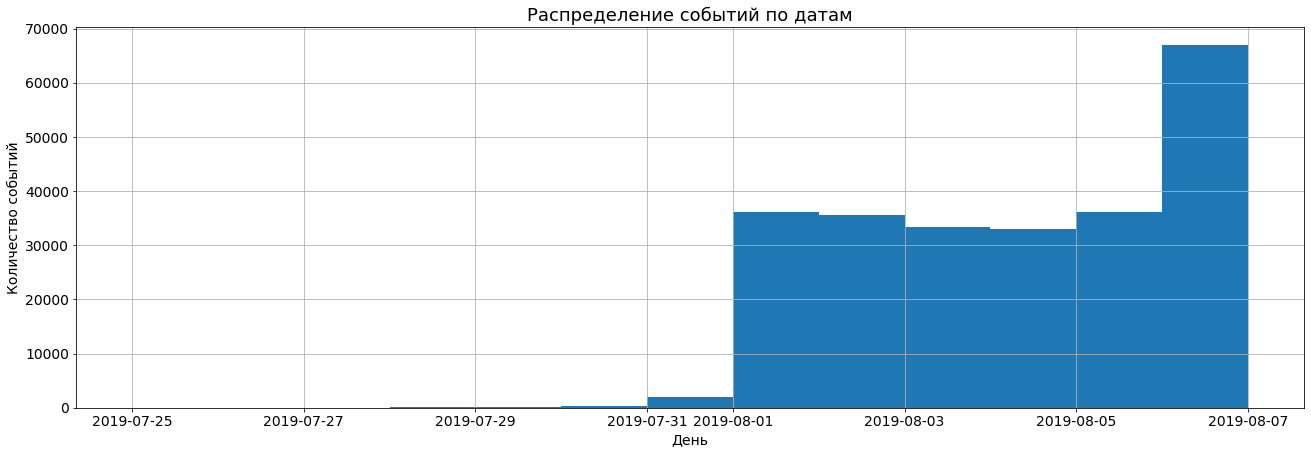

In [42]:
# Построим гистрограмму по времени
plt.rcParams.update({'font.size': 14})
plt.title('Распределение событий по датам', fontsize = 18 )
plt.ylabel('Количество событий', fontsize = 14)
plt.xlabel('День', fontsize = 14)
logs_exp['date'].hist(bins = 13, figsize = (22,7))
plt.show()

- Основная активность пользователей начинается с 1 августа 2019, поэтому сделаем срез по этой дате

In [44]:
# Срез данных по дате
logs_exp_query = logs_exp.query("date>='2019-08-01'")
logs_exp_query['date'].min(), logs_exp_query['date'].max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-08-07 00:00:00'))

In [46]:
# Количество потерянных событий после среза
print('Количество потерянных событий')
print('{:.2%}'.format((1-logs_exp_query['event_name'].count()/logs_exp['event_name'].count())),'-',\
     logs_exp['event_name'].count()-logs_exp_query['event_name'].count())
print()

Количество потерянных событий
1.16% - 2826



In [47]:
# Количество потерянных уникальных пользователей после среза
print('Количество потерянных уникальных пользователей')
print('{:.2%}'.format((1-logs_exp_query['device_id_hash'].nunique()/logs_exp['device_id_hash'].nunique())),'-',\
     logs_exp['device_id_hash'].nunique()-logs_exp_query['device_id_hash'].nunique())

Количество потерянных уникальных пользователей
0.23% - 17


<div class="alert alert-success">

<b>✔️ Комментарий ревьюера:</b> Да, потери незначительны

</div>

In [48]:
print('Проверка на вхождение пользователей во все группы')
logs_exp_query['expld'].value_counts()

Проверка на вхождение пользователей во все группы


248    84563
246    79302
247    77022
Name: expld, dtype: int64

<div style="border:solid blue 2px; padding: 20px"> <b>Вывод:</b><br>
На этапе обработки данных были сделаны следующие преобразования:
    
    1. Изменены наименования столбцов
    2. Преобразован столбец event_times_tamp в формат datetime
    3. Добавлен столбце date c форматом datetime64[ns]
    4. Сделан срез данных с периодом в 7 дней с 2019-08-01 по 2019-08-07
    5. Потеря данных после среза по количеству событий составила 1.16% (2826 событий)
    6. Потеря данных после среза по количеству уникальных пользователей составила 0.23% (17 уникальных пользователей)
    7. После среза в выборке остались пользователи из всех трех групп
    8. Потеря данных в 1% не повлияет на конечный результат при дальнейшем анализе 
</div>  

## Воронка событий

### Какие события встречаются в лого

In [49]:
logs_exp_query['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

- Main Screen Appear - переход на главную страницу
- Offers Screen Appear - появление экрана предложений
- Cart Screen Appear - переход в корзину
- Payment Screen Successful - успешная оплата товара
- Tutorial - обучение

### Сколько пользователей совершали каждое из этих событий

In [51]:
# Расчет количества уникальных пользователей по событиям
logs_group = logs_exp_query.groupby('event_name').agg({'device_id_hash':'nunique'}).reset_index()\
.sort_values(by='device_id_hash', ascending = False)
logs_group

,event_name,device_id_hash
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [52]:
# Расчет воронки на каждом этапе продаж в процентах
logs_group['share'] = round(logs_group['device_id_hash']/logs_exp_query['device_id_hash'].nunique()*100)
logs_group

,event_name,device_id_hash,share
1,MainScreenAppear,7419,98.0
2,OffersScreenAppear,4593,61.0
0,CartScreenAppear,3734,50.0
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.0


Вероятнее всего, обучение происходит на этапе знакомства с приложением, возможно до момента открытия главной страницы. Далеко не все пользователи проходят его. Поэтому этап Tutorial не будем учитывать в нашей воронке продаж 

In [53]:
print('MainScreenAppear: {:.0%}'.format(1))
print('OffersScreenAppear: {:.0%}'.format(logs_group['device_id_hash'][2]/logs_group['device_id_hash'][1]))
print('CartScreenAppear: {:.0%}'.format(logs_group['device_id_hash'][0]/logs_group['device_id_hash'][2]))
print('PaymentScreenSuccessful: {:.0%}'.format(logs_group['device_id_hash'][3]/logs_group['device_id_hash'][0]))
print('Доля пользователей дошедших от первого события до оплаты: {:.0%}'\
      .format(logs_group['device_id_hash'][3]/logs_group['device_id_hash'][1]))

MainScreenAppear: 100%
OffersScreenAppear: 62%
CartScreenAppear: 81%
PaymentScreenSuccessful: 95%
Доля пользователей дошедших от первого события до оплаты: 48%


In [54]:
# Воронка продаж
fig = go.Figure(
    go.Funnel(
        y=[
            'MainScreenAppear',
            'OffersScreenAppear',
            'CartScreenAppear',
            'PaymentScreenSuccessful',
        ],
        x=[7419, 4593, 3734, 3539],
    )
)
fig.show()

<div style="border:solid blue 2px; padding: 10px"> <b>Вывод:</b><br>
Воронка продаж показала следующие результаты:
    
1. В воронке продаж присутствуют следующие события

    - Main Screen Appear - переход на главную страницу
    - Offers Screen Appear - появление экрана предложений
    - Cart Screen Appear - переход в корзину
    - Payment Screen Successful - успешная оплата товара
    - Tutorial - обучение

    
2. Самое частое событие в логе это 'Main Screen Appear' 117328. Эти события совершили 7419 уникальных пользователей это порядка 98% всех клиентов.
    
3. Распределение событий по количеству пользователей
    - MainScreenAppear	7419
    - OffersScreenAppear	4593
    - CartScreenAppear	3734
    - PaymentScreenSuccessful	3539
    - Tutorial	840

    
4. Лишним этапом можно назвать "Tutorial". Вероятнее всего, обучение происходит на этапе знакомства с приложением, возможно до момента открытия главной страницы. Далеко не все пользователи проходят его. Поэтому этап Tutorial не будем учитывать в нашей воронке продаж

5. Воронка продаж имеет следующее распределение по процентам
    - MainScreenAppear: 100%
    - OffersScreenAppear: 62%
    - CartScreenAppear: 81%
    - PaymentScreenSuccessful: 95%

    
6. Самая маленькая конверсия при переходе с этапа 'Main Screen Appear' на этап 'Offers Screen Appear'
    
7. Доля пользователей дошедших от первого события до оплаты: 48%

</div>  

## Анализ эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [55]:
group_expld = logs_exp_query.groupby('expld').agg({'device_id_hash':'nunique'}).reset_index()
group_expld

,expld,device_id_hash
0,246,2484
1,247,2513
2,248,2537


В трех группах примерно одинаковое количество уникальных пользователей около 2.5 тыс

### Если ли статистические критерии разницу между выборками 246 и 247.

<div style="border:solid black 2px; padding: 20px"> <b>Нулевая гипотеза:</b><br>
 Разница долей пользователей групп А/А (246/247) относительно общей выборки статистически не значима, доли равны
 
 <b>Альтернативная гипотеза:</b><br>
 Разница долей пользователей групп А/А (246/247) относительно общей выборки статистически значима, доли не равны
</div>

<b>Z-test<b>

In [56]:
group_246 = group_expld.loc[group_expld['expld']==246,'device_id_hash'].sum()/group_expld['device_id_hash'].sum()
group_247 = group_expld.loc[group_expld['expld']==247,'device_id_hash'].sum()/group_expld['device_id_hash'].sum()
#group_247 = len(logs_exp_query.loc[logs_exp_query['expld']==247])/(len(logs_exp_query.loc[logs_exp_query['expld']==246])+len(logs_exp_query.loc[logs_exp_query['expld']==247]))

In [57]:
# Доли в первой и второй группе 
alpha = 0.05
p1 = group_246
p2 = group_247
    
    #пропорция успехов в комбинированном датасете:
p_combined = (group_expld.loc[group_expld['expld']==246,'device_id_hash'].sum() + group_expld.loc[group_expld['expld']==247,'device_id_hash'].sum()) / \
(2*group_expld['device_id_hash'].sum())
    
    # разница пропорций в датасетах
difference = p1-p2
    
    #считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference/mth.sqrt(p_combined*(1-p_combined)*(2/group_expld['device_id_hash'].sum()))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)
    
    
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными\n') 

p-значение:  0.615804820320411
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



### Анализ контрольных групп 246 247

In [58]:
# Сгруппируем контрольные группы для тестирования
z_group_246 = logs_exp_query.loc[logs_exp_query['expld']==246].groupby('event_name').agg({'device_id_hash':'nunique'}).reset_index()\
.sort_values(by = 'device_id_hash', ascending = False)
z_group_247 = logs_exp_query.loc[logs_exp_query['expld']==247].groupby('event_name').agg({'device_id_hash':'nunique'}).reset_index()\
.sort_values(by = 'device_id_hash', ascending = False)
z_group_246['share'] = z_group_246['device_id_hash']/z_group_246['device_id_hash'].sum()
z_group_247['share'] = z_group_247['device_id_hash']/z_group_247['device_id_hash'].sum()

Напишем функцию для сравнения контрольных групп

In [59]:
# Функция сравнения контрольных групп с экспериментальной
def z_test (group_1, group_2,alpha):
    event_n = ['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful']
    for row in event_n:
    # Доли в первой и второй группе 
        p1 = group_1.loc[group_1['event_name']==row,'share']
        p2 = group_2.loc[group_2['event_name']==row,'share']
    
    #пропорция успехов в комбинированном датасете:
        p_combined = (group_1.loc[group_1['event_name']==row,'device_id_hash'] + group_2.loc[group_2['event_name']==row,'device_id_hash']) / \
(group_1['device_id_hash'].sum()+group_2['device_id_hash'].sum())
    
    # разница пропорций в датасетах
        difference = p1-p2
    
    #считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference/mth.sqrt(p_combined*(1-p_combined)*(1/group_1['device_id_hash'].sum()+1/group_2['device_id_hash'].sum()))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
    
    
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('Этап воронки: "{}"'.format(row))
        print('p-значение: ', p_value)

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными\n') 

<div style="border:solid black 2px; padding: 20px"> <b>Нулевая гипотеза:</b><br>
 Разница долей пользователей групп А/А (246/247) на каждом этапе воронки продаж статистически не значима, доли равны
 
 <b>Альтернативная гипотеза:</b><br>
 Разница долей пользователей групп А/А (246/247) на каждом этапе воронки продаж статистически значима, доли не равны
</div>

In [60]:
z_test(z_group_246,z_group_247,0.05)

Этап воронки: "MainScreenAppear"
p-значение:  [0.38589665]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап воронки: "OffersScreenAppear"
p-значение:  [0.86810218]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап воронки: "CartScreenAppear"
p-значение:  [0.71280924]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап воронки: "PaymentScreenSuccessful"
p-значение:  [0.47805195]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Разбиение на контрольные группы работает корректно. Между контрольными группами 246 и 247 нет различий. Невозможно отвергнуть нулевую гипотезу о равенстве двух выборок. Данные группы статистически равны

### Сравнение групп 248 с 246, 248 с 247, 248 с Sum (246,247)

<div style="border:solid blue 2px; padding: 10px"> <b>Выбор уровня статистической значимости:</b><br>

Уровень статистической значимости был выбран стандартный. Для выбора другого уровня стат. значимости необходима история тестов и какие результаты происходят после этого. Увеличение продаж, или отток клиентов и т.д.

Так как мы проводим множественного тестирование и чтобы избежать неверно принятые или отвергнутые гипотезы, воспользуемся методом Шидака для корректировки уровня стат.значимости

Количество тестов = 12

Уровень стат.значимости = 1-(1-0,05)^(1/16) = 0.0043

При тестировании гипотез с новым значением alpha, нам не удалось отвергнуть нулевую гипотезу ни в одном случае.
</div>  

In [61]:
# Отберем экспериментальную группу
z_group_248 = logs_exp_query.loc[logs_exp_query['expld']==248].groupby('event_name').agg({'device_id_hash':'nunique'}).reset_index()\
.sort_values(by = 'device_id_hash', ascending = False)
z_group_248['share'] = z_group_248['device_id_hash']/z_group_248['device_id_hash'].sum()

# Суммарная группа без экспериментальной
z_group_sum = logs_exp_query.loc[logs_exp_query['expld']!=248].groupby('event_name').agg({'device_id_hash':'nunique'}).reset_index()\
.sort_values(by = 'device_id_hash', ascending = False)
z_group_sum['share'] = z_group_sum['device_id_hash']/z_group_sum['device_id_hash'].sum()

<div style="border:solid black 2px; padding: 20px"> <b>Нулевая гипотеза:</b><br>
 Разница долей пользователей групп B/А (248/246) на каждом этапе воронки продаж статистически не значима, доли равны
 
 <b>Альтернативная гипотеза:</b><br>
 Разница долей пользователей групп B/А (248/246) на каждом этапе воронки продаж статистически значима, доли не равны
</div>

Сравнение группы 248 с 246

In [62]:
z_test(z_group_248,z_group_247,0.0043)

Этап воронки: "MainScreenAppear"
p-значение:  [0.96395635]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап воронки: "OffersScreenAppear"
p-значение:  [0.96527644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап воронки: "CartScreenAppear"
p-значение:  [0.73496329]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап воронки: "PaymentScreenSuccessful"
p-значение:  [0.7125605]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



<div style="border:solid black 2px; padding: 20px"> <b>Нулевая гипотеза:</b><br>
 Разница долей пользователей групп B/А (248/247) на каждом этапе воронки продаж статистически не значима, доли равны
 
 <b>Альтернативная гипотеза:</b><br>
 Разница долей пользователей групп B/А (248/247) на каждом этапе воронки продаж статистически значима, доли не равны
</div>

Сравнение группы 248 с 247

In [63]:
z_test(z_group_248,z_group_247,0.0043)

Этап воронки: "MainScreenAppear"
p-значение:  [0.96395635]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап воронки: "OffersScreenAppear"
p-значение:  [0.96527644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап воронки: "CartScreenAppear"
p-значение:  [0.73496329]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап воронки: "PaymentScreenSuccessful"
p-значение:  [0.7125605]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



<div style="border:solid black 2px; padding: 20px"> <b>Нулевая гипотеза:</b><br>
 Разница долей пользователей группы B(248) с объединенной группой А/A (246/247) на каждом этапе воронки продаж статистически не значима, доли равны
 
 <b>Альтернативная гипотеза:</b><br>
 Разница долей пользователей группы B(248) с объединенной группой А/A (246/247) на каждом этапе воронки продаж статистически значима, доли не равны
</div>

Сравнение группы 248 с Sum (246,247)

In [65]:
z_test(z_group_248,z_group_sum,0.0043)

Этап воронки: "MainScreenAppear"
p-значение:  [0.57886627]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап воронки: "OffersScreenAppear"
p-значение:  [0.96325525]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап воронки: "CartScreenAppear"
p-значение:  [0.54551553]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап воронки: "PaymentScreenSuccessful"
p-значение:  [0.98944572]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



<div style="border:solid blue 2px; padding: 10px"> <b>Вывод:</b><br>

1. В трех группах примерно одинаковое количество уникальных пользователей около 2.5 тыс

2. Разница в количестве целевых действий в группах A и A статистически не значима

3. Разбиение на контрольные группы работает корректно. Между контрольными группами 246 и 247 нет различий. Невозможно отвергнуть нулевую гипотезу о равенстве двух выборок. Данные группы статистически равны

4. В ходе работы было проведено 16 тестов с уровнем стат.значитмости 0,05. Разницы между контрольными и экспериментальной группой не было выявлено. 

</div>  

<div style="border:solid blue 2px; padding: 10px"> <b>Общий вывод:</b><br>
<b>На этапе обработки данных были сделаны следующие преобразования:</b><br>
    
    1. Изменены наименования столбцов
    2. Преобразован столбец event_times_tamp в формат datetime
    3. Добавлен столбце date c форматом datetime64[ns]
    4. Сделан срез данных с периодом в 7 дней с 2019-08-01 по 2019-08-07
    5. Потеря данных после среза по количеству событий составила 1.16% (2826 событий)
    6. Потеря данных после среза по количеству уникальных пользователей составила 0.23% (17 уникальных пользователей)
    7. После среза в выборке остались пользователи из всех трех групп
    8. Потеря данных в 1% не повлияет на конечный результат при дальнейшем анализе 

<b>Анализ воронки продаж:</b><br>
    
1. В воронке продаж присутствуют следующие события

    - Main Screen Appear - переход на главную страницу
    - Offers Screen Appear - появление экрана предложений
    - Cart Screen Appear - переход в корзину
    - Payment Screen Successful - успешная оплата товара
    - Tutorial - обучение

    
2. Самое частое событие в логе это 'Main Screen Appear' 117328. Эти события совершили 7419 уникальных пользователей это порядка 98% всех клиентов.
    
3. Распределение событий по количеству пользователей
    - MainScreenAppear	7419
    - OffersScreenAppear	4593
    - CartScreenAppear	3734
    - PaymentScreenSuccessful	3539
    - Tutorial	840

    
4. Лишним этапом можно назвать "Tutorial". Вероятнее всего, обучение происходит на этапе знакомства с приложением, возможно до момента открытия главной страницы. Далеко не все пользователи проходят его. Поэтому этап Tutorial не будем учитывать в нашей воронке продаж

5. Воронка продаж имеет следующее распределение по процентам
    - MainScreenAppear: 100%
    - OffersScreenAppear: 62%
    - CartScreenAppear: 81%
    - PaymentScreenSuccessful: 95%

    
6. Самая маленькая конверсия при переходе с этапа 'Main Screen Appear' на этап 'Offers Screen Appear'
    
7. Доля пользователей дошедших от первого события до оплаты: 48%

<b>Анализ групп А/А/В тестирования:</b><br>

1. В трех группах примерно одинаковое количество уникальных пользователей около 2.5 тыс

2. Разница в количестве целевых действий в группах A и A статистически не значима

3. Разбиение на контрольные группы работает корректно. Между контрольными группами 246 и 247 нет различий. Невозможно отвергнуть нулевую гипотезу о равенстве двух выборок. Данные группы статистически равны

4. В ходе работы было проведено 16 тестов с уровнем стат.значитмости 0,05. Разницы между контрольными и экспериментальной группой не было выявлено.

<b>Заключение:</b><br>
1. Менеджерам можно не переживать и смело менять дизайн приложения. Результаты тестирования показали, что разницы в долях на каждом этапе воронки продаж между контрольными и экспериментальной группами не было выявлено. Пользователи ведут себя одинаково.

2. Было найдено слабое место в воронке продаж. При переходе с первого этапа воронки MainScreenAppear на второй OffersScreenAppear остается порядка 62% всех пользователей. Это самая низкая конверсия относительно других этапов воронки. Необходимо провести дополнительное тестирование и выявить причину такого большого оттока пользователей на данном этапе.

3. Необходимо подумать над этапом Tutorial. Обучение проходит всего 11% от всех пользователей. Возможно это является причиной большого оттока пользователей при переходе с первого этапа воронки на второй. Провести анализ удобства пользовательского интерфейса, возможно потребуются доработки по части улучшения интерфейса.